# Fraud Detector- Predicting Fraudulet Financial Transactions with Machine Learning

## Importing Libraries and Fetching the Data

In [2]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [3]:
plt.style.use('fivethirtyeight')
colorPalette=["#E0D8C3","#0D97AC","#E2532F","#DDA033","#065125"]

In [4]:
fraud_data = pd.read_csv("Fraud.csv")

### Dataset Introduction

This dataset is a **synthetic simulation** generated using a tool called **PaySim**, designed to model financial transaction data and simulate fraudulent activities. PaySim leverages aggregated insights from a private dataset to create a realistic imitation of typical transaction behaviors, while also injecting instances of malicious activity. This enables the testing and evaluation of fraud detection algorithms under realistic conditions.

The simulation is based on **mobile money transactions**, using real financial logs collected over a one-month period from a mobile money service operating in an African country. The original data was provided by a multinational company that offers mobile financial services across more than 14 countries worldwide.


In [5]:
data = fraud_data.copy() #Creating a copy of the Dataframe 

In [6]:
data.shape

(6362620, 11)

The DataFrame has 6362620 records and 11 attributes.

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### DataFrame Attribute Descriptions

- **step**  
  Maps a unit of time in the real world. In this case, 1 step is 1 hour of time. Total steps: 744 (30 days simulation).

- **type**  
  Type of transaction: `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, and `TRANSFER`.

- **amount**  
  Amount of the transaction in local currency.

- **nameOrig**  
  Customer who initiated the transaction.

- **oldbalanceOrg**  
  Initial balance of the sender before the transaction.

- **newbalanceOrig**  
  New balance of the sender after the transaction.

- **nameDest**  
  Customer who received the transaction.

- **oldbalanceDest**  
  Initial balance of the recipient before the transaction.  

- **newbalanceDest**  
  New balance of the recipient after the transaction.  

- **isFraud**  
  Indicates whether the transaction was made by fraudulent agents.  

- **isFlaggedFraud**  
  Flags transactions that are illegally large (more than 200,000 in a single transaction).  
  This is part of the business model to detect and flag such suspicious activities.


# Exploratory Data Analysis

#### On whole dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


We decided to drop the "nameOrig" and "nameDest" columns because they represent customer IDs, which in their raw form don't provide meaningful information for predicting fraudulent transactions. Customer IDs have high cardinality, leading to potential overfitting, where the model may memorize specific customer patterns rather than learning generalizable fraud indicators. Domain knowledge also suggests that fraudulent behavior is better detected through features related to transaction types, amounts, and changes in balances, rather than by individual customer identities. Therefore, these columns were removed to focus on more relevant features that better capture the fraud detection patterns.

In [9]:
data = data.drop(['nameOrig', 'nameDest'], axis=1)

In [10]:
data["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

C:\Users\riy\AppData\Local\Temp\ipykernel_5396\430783827.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="type", palette=colorPalette)


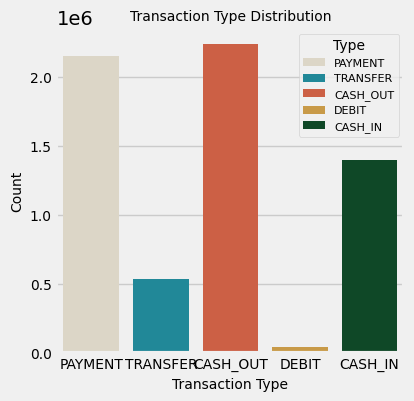

In [11]:
plt.figure(figsize=(4, 4))

sns.countplot(data=data, x="type", palette=colorPalette) 

plt.title("Transaction Type Distribution", fontsize=10)
plt.xlabel("Transaction Type", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title="Type", labels=data["type"].unique(), fontsize=8, title_fontsize=10)

plt.show()

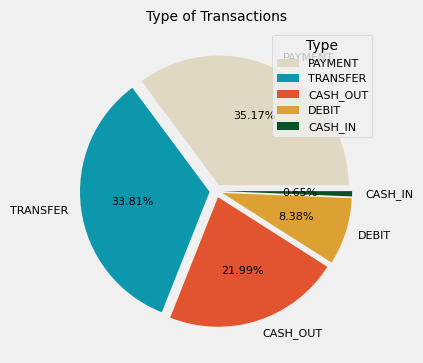

In [121]:
plt.figure(figsize=(4, 4))
type_counts = data['type'].value_counts()

plt.pie(type_counts, labels=data["type"].unique(), autopct='%1.2f%%', explode=[0.05]*len(type_counts), colors=colorPalette, textprops={'fontsize': 8})
plt.legend(title="Type", labels=data["type"].unique(), fontsize=8, title_fontsize=10)
plt.title("Type of Transactions", fontsize=10)
plt.show()

In [13]:
data["isFraud"].value_counts() 

isFraud
0    6354407
1       8213
Name: count, dtype: int64

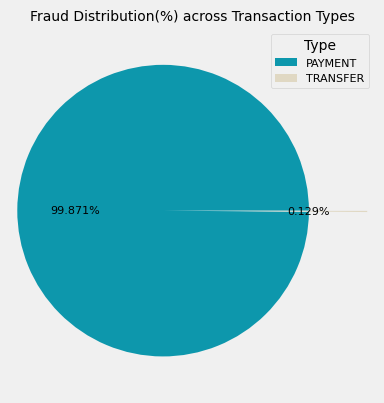

In [124]:
plt.figure(figsize=(4.5, 4.5))
fraud_counts = data['isFraud'].value_counts()

plt.pie(fraud_counts, autopct='%1.3f%%', explode=[0.2]*len(fraud_counts), colors=[colorPalette[1],colorPalette[0]], textprops={'fontsize': 8})
plt.legend(title="Type", labels=data["type"].unique(), fontsize=8, title_fontsize=10)
plt.title("Fraud Distribution(%) across Transaction Types", fontsize=10)
plt.show()

The dataset is highly imbalanced, with fraudulent transactions being in minority.

In [15]:
fraud_rate_by_type = data.groupby('type')['isFraud'].mean().sort_values(ascending=False) * 100

print(fraud_rate_by_type)

type
TRANSFER    0.768799
CASH_OUT    0.183955
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


Fraud is concentrated entirely in TRANSFER and CASH_OUT transactions.

The other types- CASH_IN, DEBIT, and PAYMENT show no fraudulent activity in your dataset.

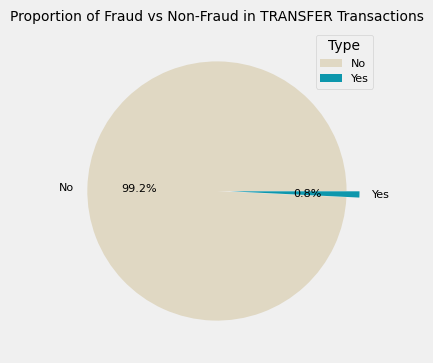

In [16]:
fraud_counts_transfer = data[data["type"]=="TRANSFER"]["isFraud"].value_counts()

labels= ["No", "Yes"]
plt.figure(figsize=(4, 4))
plt.pie(fraud_counts_transfer, labels=labels, autopct='%1.1f%%', colors=colorPalette, explode=[0, 0.1], textprops={'fontsize': 8})
plt.legend(title="Type", labels=labels, fontsize=8, title_fontsize=10)
plt.title("Proportion of Fraud vs Non-Fraud in TRANSFER Transactions", fontsize = 10)
plt.show()

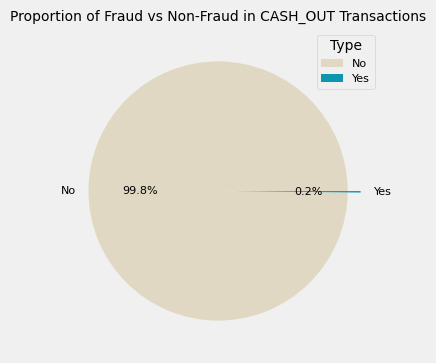

In [17]:
fraud_counts_transfer = data[data["type"]=="CASH_OUT"]["isFraud"].value_counts()

labels= ["No", "Yes"]
plt.figure(figsize=(4, 4))
plt.pie(fraud_counts_transfer, labels=labels, autopct='%1.1f%%', colors=colorPalette, explode=[0, 0.1], textprops={'fontsize': 8})
plt.legend(title="Type", labels=labels, fontsize=8, title_fontsize=10)
plt.title("Proportion of Fraud vs Non-Fraud in CASH_OUT Transactions", fontsize = 10)
plt.show()

array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

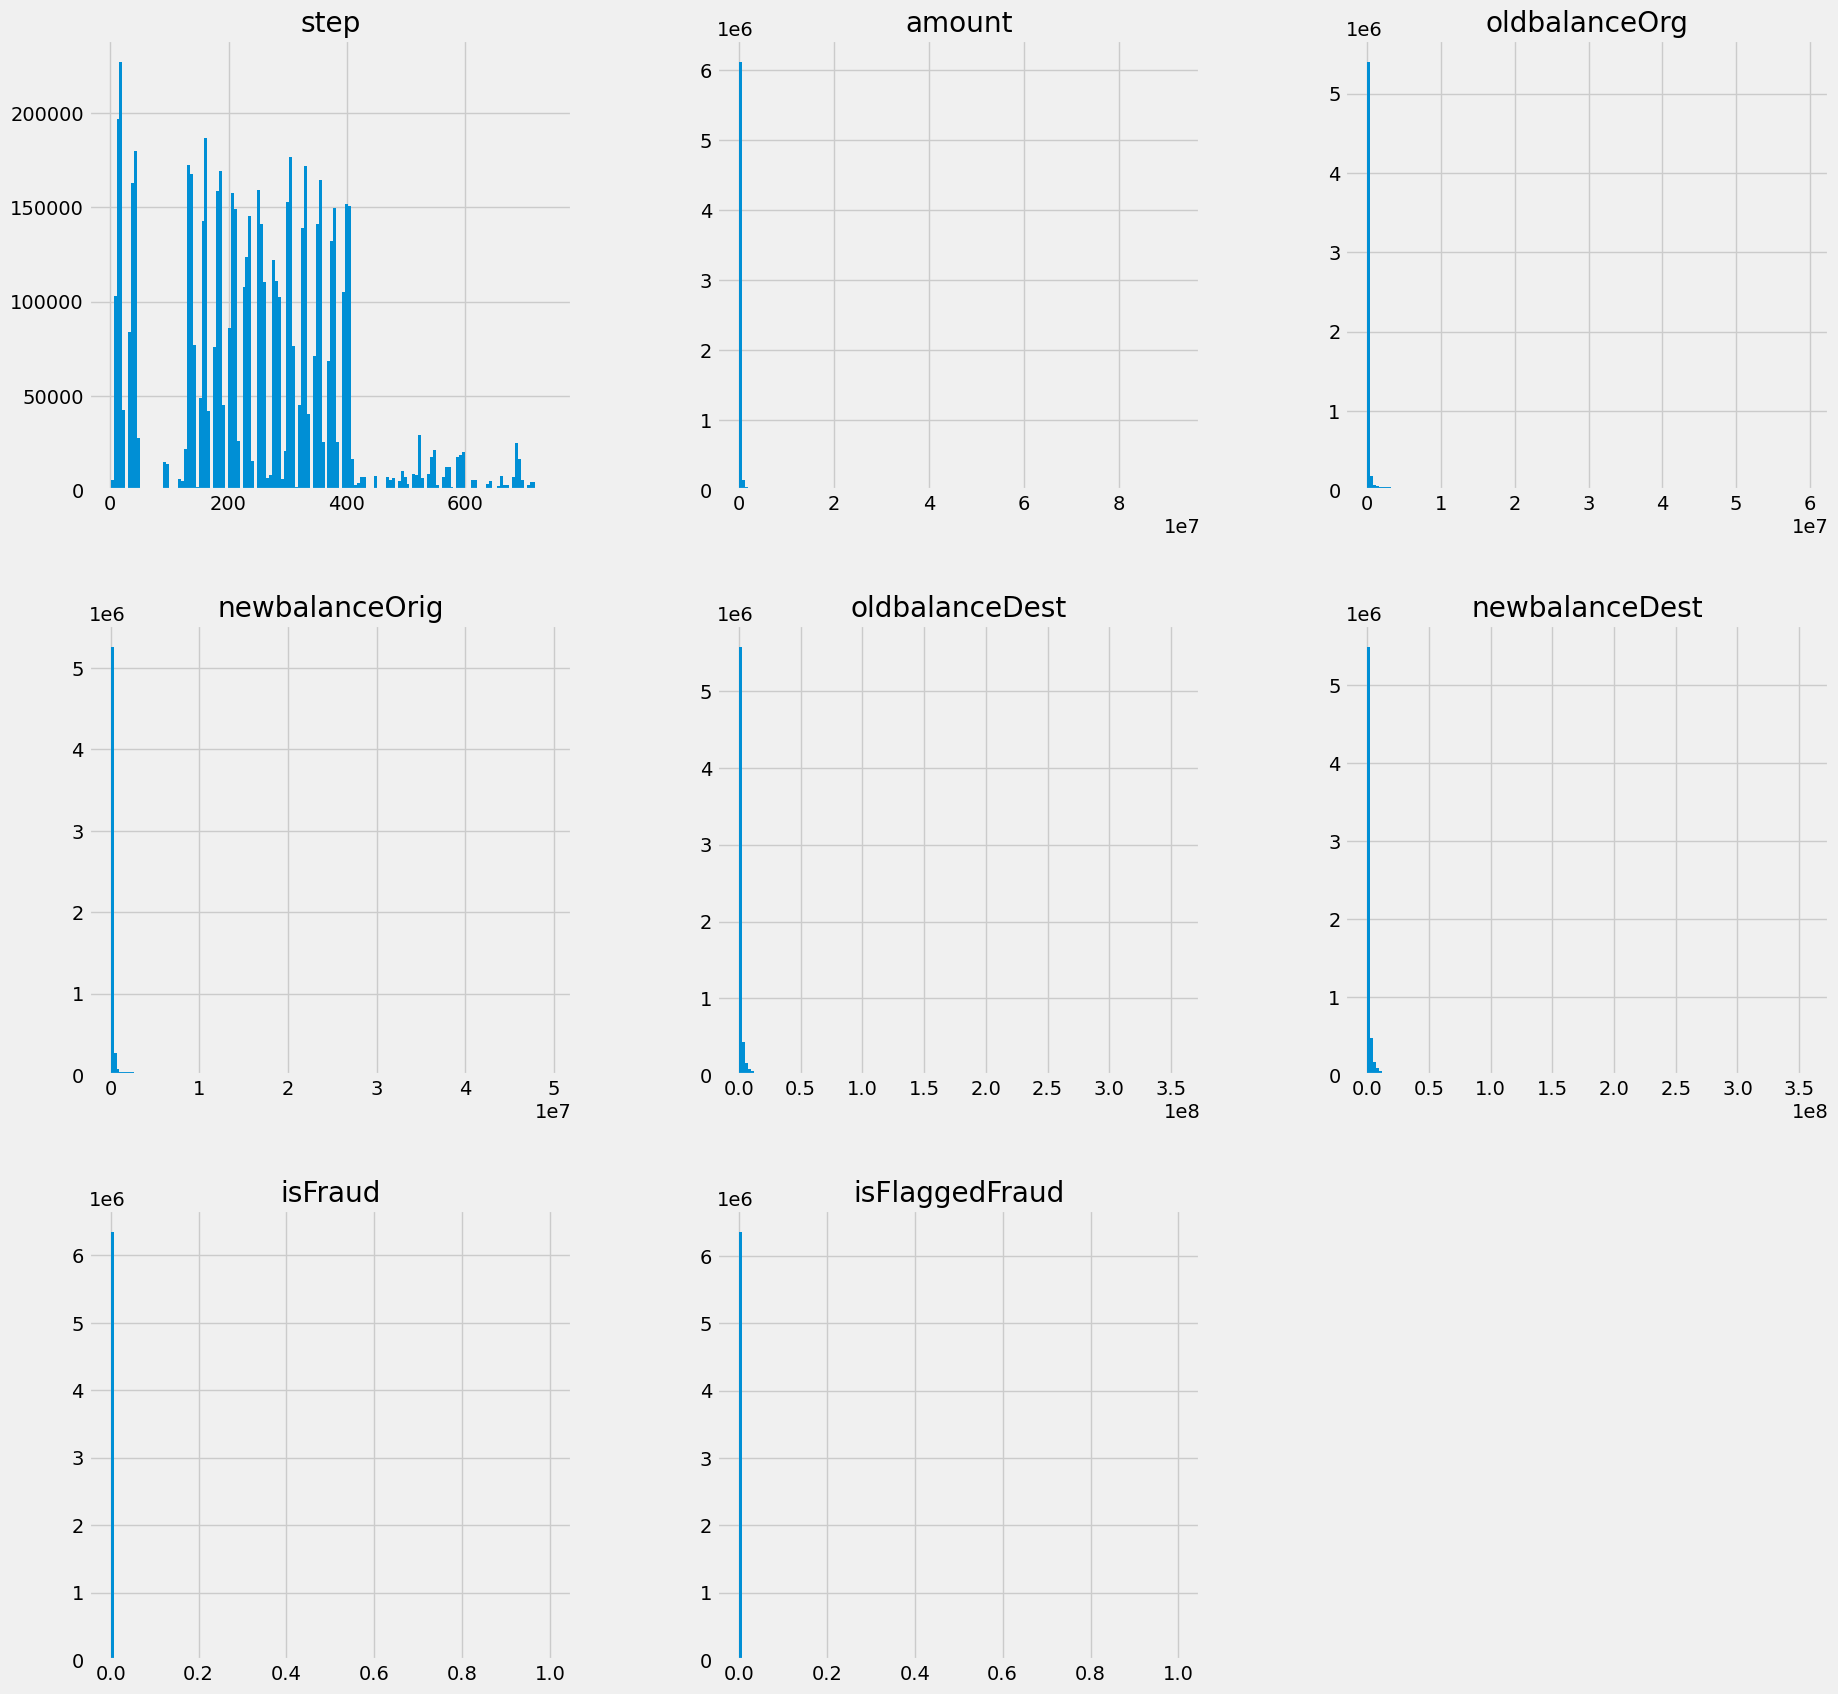

In [18]:
data.hist(bins=150, figsize=(20,20))

The histogram plots do not clearly reveal the distributions for most features apart from the step attribute. 
The remaining features display right-skewed distributions. To address this, we will apply a log(1 + x) transformation, which helps reduce the skewness and stabilize variance. We use log(1 + x) instead of log(x) to avoid runtime warnings or errors when the value of x is zero.

In [19]:
log_data = data.copy()
numeric_cols = log_data.select_dtypes(include=["number"]).columns


#Excluding the isFlggedFraud and isFraud columns (Since these are binary- categorical features)

numeric_cols = [col for col in numeric_cols if col!="isFlaggedFraud" and col!="isFraud"]
log_data[numeric_cols] = log_data[numeric_cols].apply(lambda x: np.log1p(1+x))

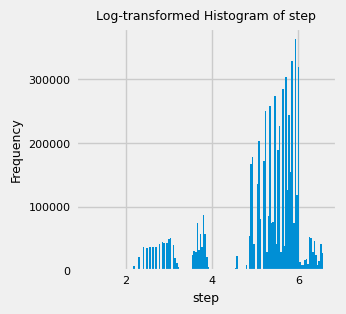

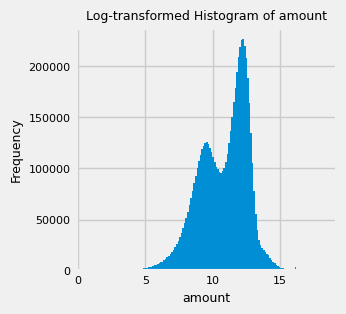

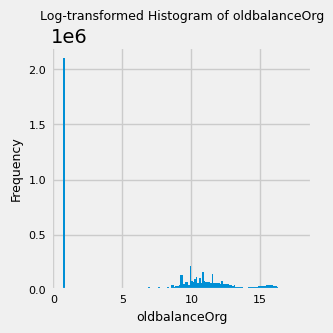

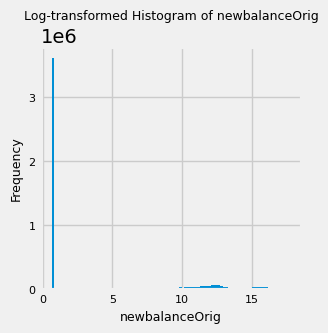

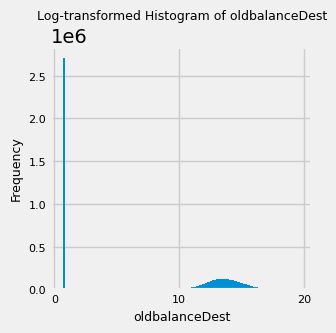

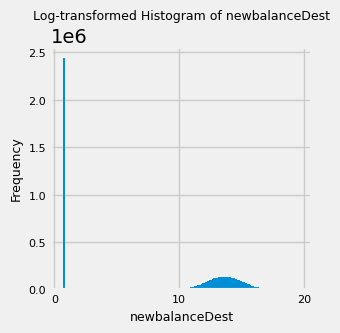

In [20]:
for col in numeric_cols:
    log_data[col].hist(bins=150, figsize=(3,3))
    plt.title(f'Log-transformed Histogram of {col}', fontsize=9)
    plt.xlabel(col,fontsize=9)
    plt.ylabel('Frequency',fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

# Data Preparation for ML Algorithms

### Splitting the Dataset into Train and Test Datasets

We are going to split the dataset in such a way that:

- Each transaction type (e.g., "TRANSFER", "CASH_OUT", etc.) is represented proportionally in both train and test sets.
- Within each transaction type, both fraudulent (isFraud = 1) and non-fraudulent (isFraud = 0) transactions are proportionally prese clearer view of the data distributions and their variations.

In [30]:
# Create a stratification key

data['stratify_key'] = data['type'].astype(str) + "_" + data['isFraud'].astype(str)

In [31]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [32]:
for train_index, test_index in split.split(data, data["stratify_key"]):
    strat_train_set = data.loc[train_index].drop(columns='stratify_key') #dropping the stratify_key column
    strat_test_set = data.loc[test_index].drop(columns='stratify_key')

In [33]:
# Function to compute fraud proportions per type
def fraud_proportions_by_type(df):
    return (df.groupby(['type', 'isFraud']).size() / df.groupby('type').size())

# Original proportions
print("Original data proportions (within each type):")
print(fraud_proportions_by_type(data), end="\n\n")

# Train set proportions
print("Train data proportions (within each type):")
print(fraud_proportions_by_type(strat_train_set), end="\n\n")

# Test set proportions
print("Test data proportions (within each type):")
print(fraud_proportions_by_type(strat_test_set), end="\n\n")

Original data proportions (within each type):
type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998160
          1          0.001840
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.992312
          1          0.007688
dtype: float64

Train data proportions (within each type):
type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998160
          1          0.001840
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.992311
          1          0.007689
dtype: float64

Test data proportions (within each type):
type      isFraud
CASH_IN   0          1.000000
CASH_OUT  0          0.998161
          1          0.001839
DEBIT     0          1.000000
PAYMENT   0          1.000000
TRANSFER  0          0.992316
          1          0.007684
dtype: float64



In [34]:
test_data = strat_test_set.copy()

In [35]:
train_data = strat_train_set.copy()

In [36]:
train_data.shape

(5090096, 9)

In [37]:
corr_matrix = train_data.select_dtypes(include=["number"]).corr()
corr_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022451,-0.010065,-0.010305,0.027775,0.026005,0.031438,0.003437
amount,0.022451,1.000000,-0.002721,-0.007866,0.291338,0.457025,0.076687,0.012280
oldbalanceOrg,-0.010065,-0.002721,1.000000,0.998800,0.066063,0.041858,0.010174,0.003378
newbalanceOrig,-0.010305,-0.007866,0.998800,1.000000,0.067643,0.041666,-0.008085,0.003325
oldbalanceDest,0.027775,0.291338,0.066063,0.067643,1.000000,0.976444,-0.005797,-0.000519
newbalanceDest,0.026005,0.457025,0.041858,0.041666,0.976444,1.000000,0.000596,-0.000534
isFraud,0.031438,0.076687,0.010174,-0.008085,-0.005797,0.000596,1.000000,0.044450
isFlaggedFraud,0.003437,0.012280,0.003378,0.003325,-0.000519,-0.000534,0.044450,1.000000


In [38]:
corr_matrix["isFraud"].sort_values(ascending=False)

isFraud           1.000000
amount            0.076687
isFlaggedFraud    0.044450
step              0.031438
oldbalanceOrg     0.010174
newbalanceDest    0.000596
oldbalanceDest   -0.005797
newbalanceOrig   -0.008085
Name: isFraud, dtype: float64

### Feature Engineering- Attribute Combinations

Let us create some additional attributes which could help us seperate the fraudulent transactions from the rest of the data.

In [39]:
train_data['amount_to_oldbalanceOrg_ratio'] = train_data['amount'] / (data['oldbalanceOrg'])
train_data['amount_to_oldbalanceDest_ratio'] = train_data['amount'] / (data['oldbalanceDest'])

train_data['amount_to_newbalanceOrig_ratio'] = train_data['amount'] / (data['newbalanceOrig'])
train_data['amount_to_newbalanceDest_ratio'] = train_data['amount'] / (data['newbalanceDest'])

train_data['balance_change_orig'] = train_data['oldbalanceOrg'] - train_data['newbalanceOrig']
train_data['balance_change_dest'] = train_data['newbalanceDest'] - train_data['oldbalanceDest']

train_data['hour'] = train_data['step'] % 24

In [40]:
corr_matrix = train_data.select_dtypes(include=["number"]).corr()

In [41]:
corr_matrix["isFraud"].sort_values(ascending=False)

isFraud                           1.000000
balance_change_orig               0.361250
amount                            0.076687
isFlaggedFraud                    0.044450
step                              0.031438
balance_change_dest               0.026893
oldbalanceOrg                     0.010174
newbalanceDest                    0.000596
amount_to_oldbalanceDest_ratio    0.000127
amount_to_newbalanceOrig_ratio    0.000078
amount_to_newbalanceDest_ratio   -0.000021
amount_to_oldbalanceOrg_ratio    -0.001248
oldbalanceDest                   -0.005797
newbalanceOrig                   -0.008085
hour                             -0.031246
Name: isFraud, dtype: float64

We observe that some of the newly added features, specifically balance_change_orig, balance_change_dest, and hour, show a strong correlation with fraudulent activities.

In [43]:
train_set = strat_train_set.drop("isFraud", axis=1) #Dropping the target attribute
train_labels = strat_train_set["isFraud"].copy()

In [44]:
X_test = strat_test_set.drop("isFraud", axis=1)
test_labels = strat_test_set["isFraud"].copy()

### Data Cleaning

#### Treat missing values

In [45]:
missing_values = train_set.isnull().sum()
missing_values

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

There are no missing values in the training dataset. However, the test set may contain missing values, so let us prepare to handle any missing data by identifying the values to be imputed in case we encounter such instances.

For numerical features, we are using the median to replace missing values because it is more robust to outliers and better handles skewed distributions compared to the mean, ensuring that the imputation reflects the central tendency of the data without being distorted by extreme values.

For categorical features, we are using the mode (the most frequent value) to replace missing values.

In [46]:
imputer = SimpleImputer(strategy="median")

train_set_num = train_set.drop(["type","isFlaggedFraud"], axis=1)

#imputer.fit(train_set_num)

In [47]:
cat_encoder = OneHotEncoder()

train_set_cat = train_set[["type","isFlaggedFraud"]]

#cat_encoder.fit(train_set_cat)

In [48]:
step_ix = 0
amount_ix = 1
oldbalanceOrg_ix = 2
newbalanceOrig_ix = 3
oldbalanceDest_ix = 4
newbalanceDest_ix = 5


#This class adds three additional attributes to the dataset- balance_change_orig, balance_change_dest
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):  # No hyperparameters for now
        pass

    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        balance_change_orig = X[:, oldbalanceOrg_ix] - X[:, newbalanceOrig_ix]
        balance_change_dest = X[:, newbalanceDest_ix] - X[:, oldbalanceDest_ix]
        hour = X[:, step_ix] % 24

        return np.c_[X, balance_change_orig, balance_change_dest, hour]

In [50]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [51]:
num_attribs = list(train_set_num.columns)

cat_attribs = ["type", "isFlaggedFraud"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])

In [120]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['step', 'amount', 'oldbalanceOrg',
                                  'newbalanceOrig', 'oldbalanceDest',
                                  'newbalanceDest']),
                                ('cat', OneHotEncoder(),
                                 ['type', 'isFlaggedFraud'])])

In [52]:
train_data_transformed = full_pipeline.fit_transform(train_set)

### Addressing Class Imbalance in the Target Column

In [53]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(train_data_transformed, train_labels)

In [54]:
print(f"Original class distribution in y_train: {train_labels.value_counts()}")
print(f"Resampled class distribution in y_train: {y_train_res.value_counts()}")

Original class distribution in y_train: isFraud
0    5083525
1       6571
Name: count, dtype: int64
Resampled class distribution in y_train: isFraud
0    5083525
1    5083525
Name: count, dtype: int64


In [55]:
# Transform the X_test using the same pipeline (only transform, not fit)
X_test_transformed = full_pipeline.transform(X_test)

# Training and Evaluation

### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000)

In [57]:
# 3-Fold Cross-Validation (on resampled training set)
cv_scores = cross_val_score(log_reg, X_train_res, y_train_res, cv=3, scoring='f1')

In [58]:
print("3-Fold CV F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())

3-Fold CV F1 Scores: [0.96775079 0.96744811 0.96767855]
Mean F1 Score: 0.9676258172467783


In [59]:
# Fit the model on the entire resampled training data
log_reg.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000)

In [60]:
# Make predictions on the transformed test set
train_pred_log_reg = log_reg.predict(train_data_transformed)
test_pred_log_reg = log_reg.predict(X_test_transformed)

In [61]:
# Evaluate the model on original train labels
print("\nLogistic Regression Classification Report on Training Data:\n")
print(classification_report(train_labels, train_pred_log_reg))


Logistic Regression Classification Report on Training Data:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   5083525
           1       0.03      0.98      0.06      6571

    accuracy                           0.96   5090096
   macro avg       0.51      0.97      0.52   5090096
weighted avg       1.00      0.96      0.98   5090096



In [62]:
# Evaluate the model on original test labels
print("Logistic Regression Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_log_reg))

Logistic Regression Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270882
           1       0.03      0.98      0.06      1642

    accuracy                           0.96   1272524
   macro avg       0.51      0.97      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



In [63]:
from sklearn.metrics import confusion_matrix

train_conf_matrix = confusion_matrix(train_labels, train_pred_log_reg)

print("Logistic Regression Confusion Matrix on Train Data:\n")
print(train_conf_matrix)

Logistic Regression Confusion Matrix on Train Data:

[[4873052  210473]
 [    160    6411]]


In [64]:
test_conf_matrix = confusion_matrix(test_labels, test_pred_log_reg)

print("Logistic Regression Confusion Matrix on Test Data:\n")
print(test_conf_matrix)

Logistic Regression Confusion Matrix on Test Data:

[[1218350   52532]
 [     33    1609]]


### Support Vector Machine (LinearSVC)

In [65]:
from sklearn.svm import LinearSVC

In [66]:
#Initialize model
svm_clf = LinearSVC(max_iter=10000)

In [67]:
# Fit on resampled training data
svm_clf.fit(X_train_res, y_train_res)

LinearSVC(max_iter=10000)

In [68]:
# Make predictions on the transformed test set
train_pred_svm_clf = svm_clf.predict(train_data_transformed)
test_pred_svm_clf = svm_clf.predict(X_test_transformed)

In [69]:
# Evaluate the model on original train labels
print("Linear SVM Classification Report on Train Data:\n")
print(classification_report(train_labels, train_pred_svm_clf))

Linear SVM Classification Report on Train Data:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   5083525
           1       0.03      0.96      0.06      6571

    accuracy                           0.96   5090096
   macro avg       0.51      0.96      0.52   5090096
weighted avg       1.00      0.96      0.98   5090096



In [70]:
# Evaluate the model on original test labels
print("Linear SVM Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_svm_clf))

Linear SVM Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270882
           1       0.03      0.97      0.06      1642

    accuracy                           0.96   1272524
   macro avg       0.51      0.96      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



In [71]:
train_conf_matrix = confusion_matrix(train_labels, train_pred_svm_clf)

print("Linear SVM Confusion Matrix on Train Data:\n")
print(train_conf_matrix)

Linear SVM Confusion Matrix on Train Data:

[[4874814  208711]
 [    234    6337]]


In [72]:
test_conf_matrix = confusion_matrix(test_labels, test_pred_svm_clf)

print("Linear SVM Confusion Matrix on Test Data:\n")
print(test_conf_matrix)

Linear SVM Confusion Matrix on Test Data:

[[1218804   52078]
 [     50    1592]]


### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [74]:
tree_clf = DecisionTreeClassifier(
    max_depth=10,         # limit depth to control complexity
    min_samples_split=100,  # reduce number of splits = faster
    min_samples_leaf=500,
    max_leaf_nodes=1000,   # Limit the number of leaf nodes to avoid excessive tree growth
    criterion="gini",      # Use Gini index (faster than entropy)# each leaf should have at least 50 samples
    random_state=42
)

In [75]:
tree_clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=1000, min_samples_leaf=500,
                       min_samples_split=100, random_state=42)

In [76]:
# Make predictions on the transformed test set
train_pred_tree_clf = tree_clf.predict(train_data_transformed)
test_pred_tree_clf = tree_clf.predict(X_test_transformed)

In [77]:
# Evaluate the model on original train labels
print("Decision Tree Classification Report on Train Data:\n")
print(classification_report(train_labels, train_pred_tree_clf))

Decision Tree Classification Report on Train Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083525
           1       0.16      0.99      0.27      6571

    accuracy                           0.99   5090096
   macro avg       0.58      0.99      0.63   5090096
weighted avg       1.00      0.99      1.00   5090096



In [78]:
# Evaluate the model on original test labels
print("Decision Tree Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_tree_clf))

Decision Tree Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270882
           1       0.15      0.99      0.27      1642

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524



In [79]:
train_conf_matrix = confusion_matrix(train_labels, train_pred_tree_clf)

print("Decision Tree Confusion Matrix on Train Data:\n")
print(train_conf_matrix)

Decision Tree Confusion Matrix on Train Data:

[[5048468   35057]
 [     44    6527]]


In [80]:
test_conf_matrix = confusion_matrix(test_labels, test_pred_tree_clf)

print("Decision Tree Confusion Matrix on Test Data:\n")
print(test_conf_matrix)

Decision Tree Confusion Matrix on Test Data:

[[1262005    8877]
 [     20    1622]]


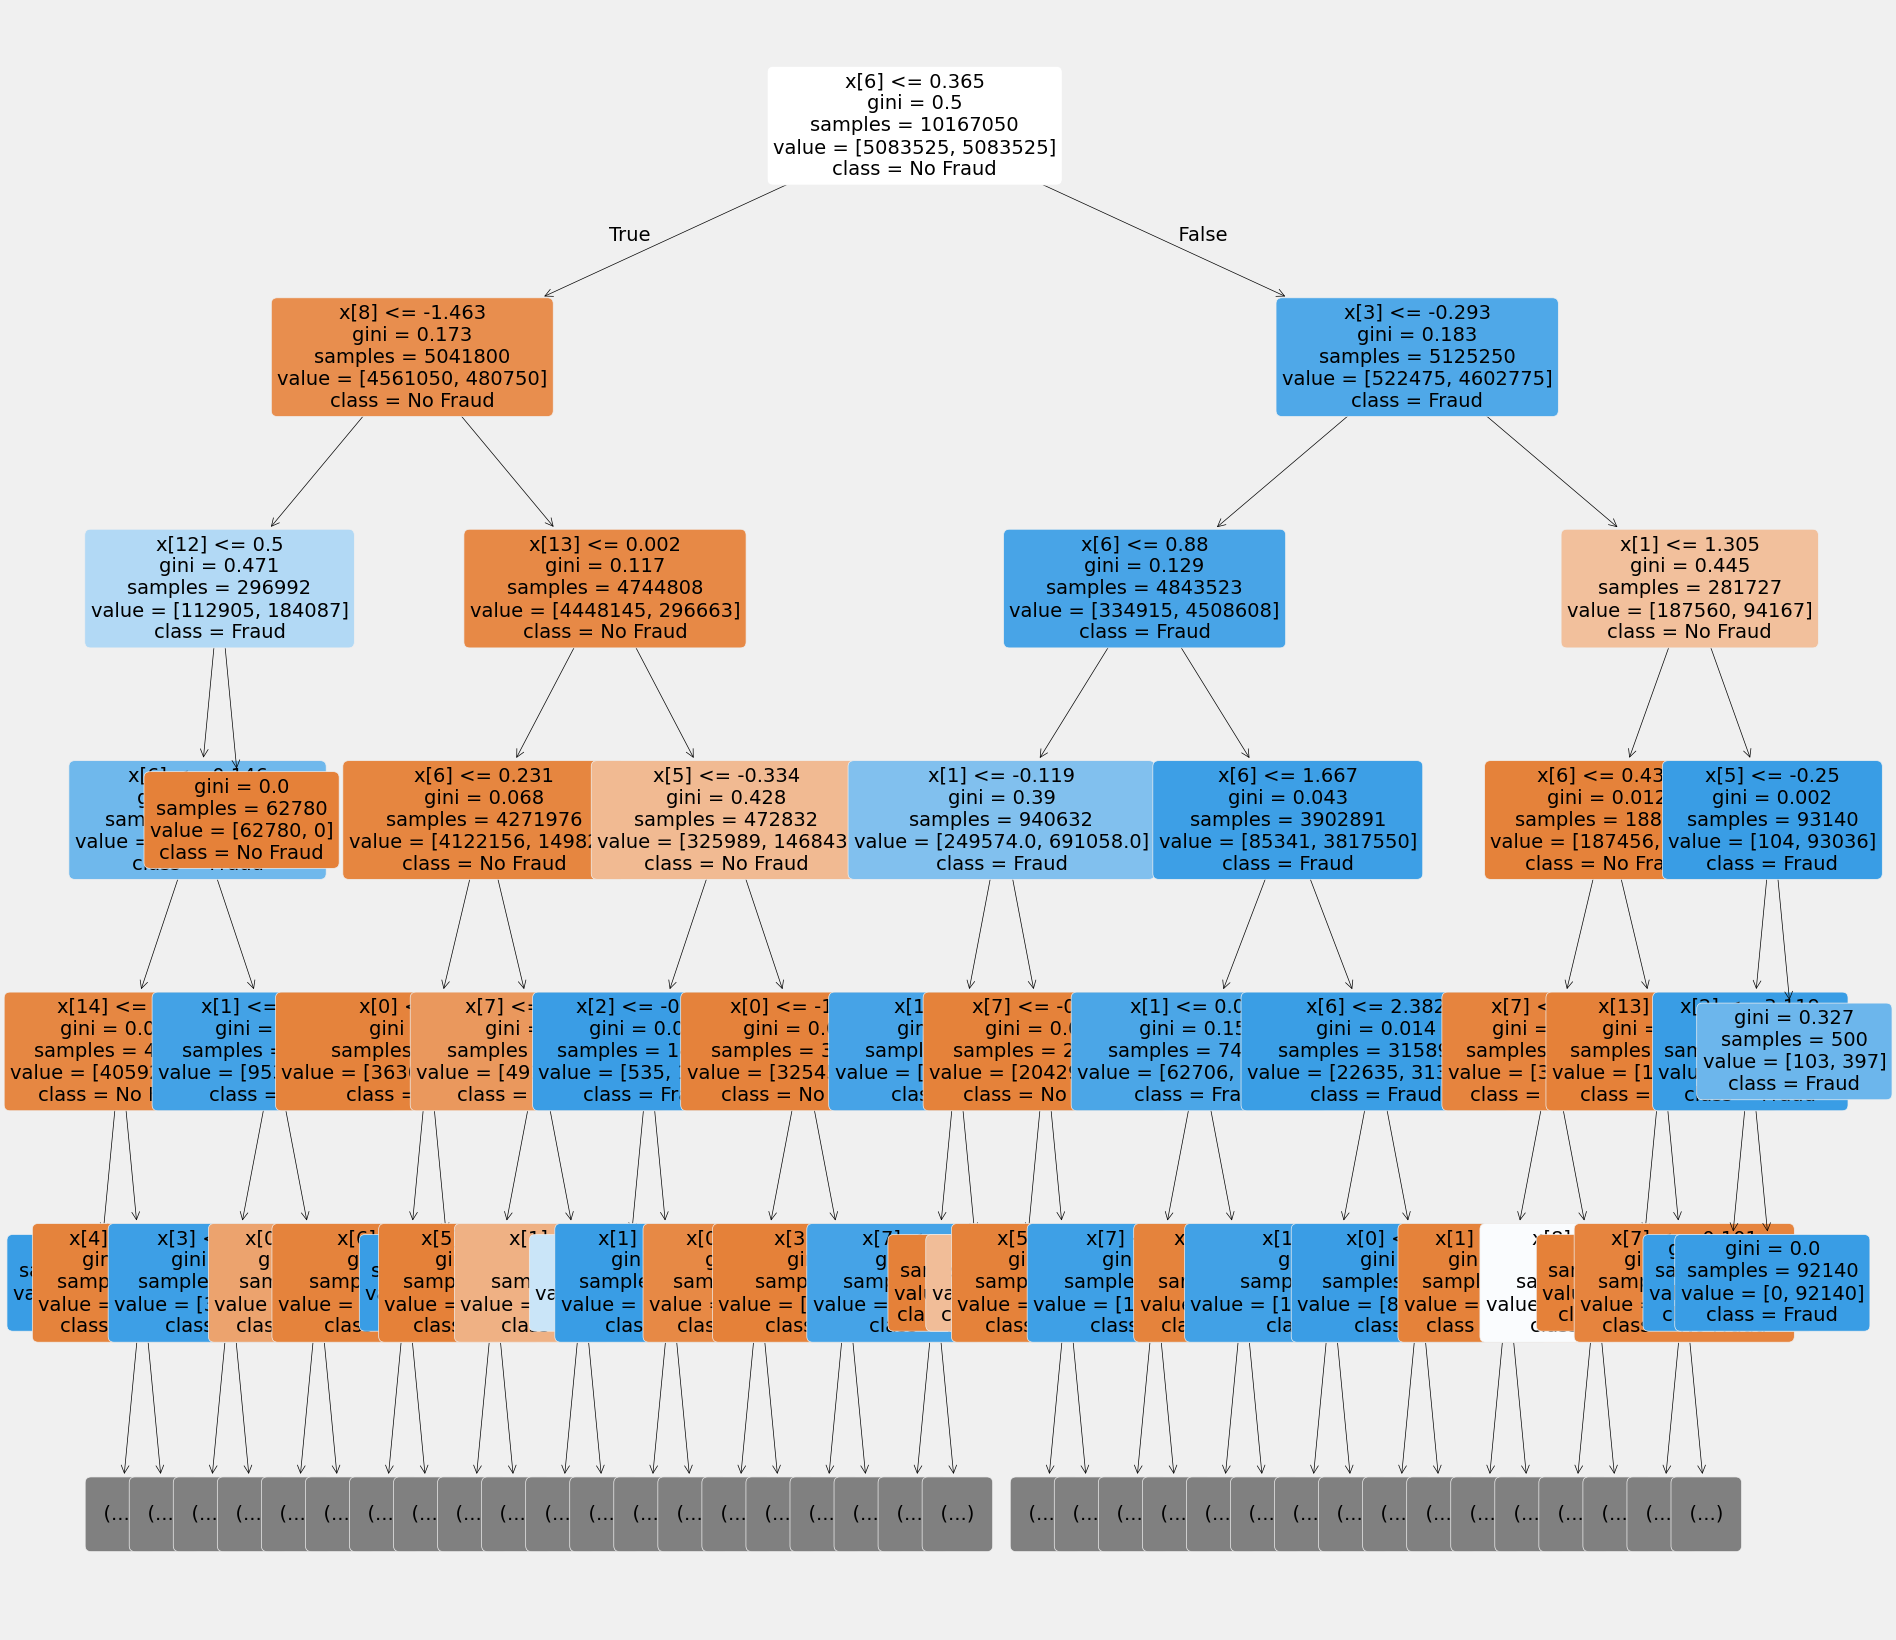

In [81]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Plot the tree (limited size for readability)
plt.figure(figsize=(20, 20))  # Resize the figure for better visualization
plot_tree(tree_clf, filled=True, class_names=["No Fraud", "Fraud"], rounded=True, max_depth=5,  fontsize=14)  # You can adjust max_depth
plt.show()

### Random Forest

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=10,       
    max_depth=10,           
    random_state=42,
    max_features='sqrt',    # Number of features to consider for each split (sqrt of total features)
    n_jobs=-1               # Use all CPU cores for training
)

In [84]:
# Train on resampled training data
rf_clf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [85]:
# Predictions on train and test
train_pred_rf = rf_clf.predict(train_data_transformed)
test_pred_rf = rf_clf.predict(X_test_transformed)

In [86]:
# Evaluate the model on original train labels
print("Random Forest Classification Report on Train Data:\n")
print(classification_report(train_labels, train_pred_rf))# Evaluate the model on original train labels

Random Forest Classification Report on Train Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083525
           1       0.12      1.00      0.21      6571

    accuracy                           0.99   5090096
   macro avg       0.56      0.99      0.60   5090096
weighted avg       1.00      0.99      0.99   5090096



In [87]:
# Evaluate the model on original test labels
print("Random Forest Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_rf))

Random Forest Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270882
           1       0.12      0.99      0.21      1642

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524



In [88]:
train_conf_matrix = confusion_matrix(train_labels, train_pred_rf)

print("Random Forest Confusion Matrix on Train Data:\n")
print(train_conf_matrix)

Random Forest Confusion Matrix on Train Data:

[[5034063   49462]
 [     22    6549]]


In [89]:
test_conf_matrix = confusion_matrix(test_labels, test_pred_rf)

print("Random Forest Matrix on Test Data:\n")
print(test_conf_matrix)

Random Forest Matrix on Test Data:

[[1258486   12396]
 [     13    1629]]


### Decision Tree with GridSearchCV

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10],
    'min_samples_leaf': [1000, 2000]
}

In [91]:
# Initialize the base model
dt_clf = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=3)

In [92]:
# Fit on resampled training data
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 10],
                         'min_samples_leaf': [1000, 2000]},
             scoring='f1')

In [100]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=1000, random_state=42)

In [93]:
cvres = grid_search.cv_results_

print("\nCross-validation results:")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"Mean F1 Score: {mean_score:.4f}, Parameters: {params}")


Cross-validation results:
Mean F1 Score: 0.9760, Parameters: {'max_depth': 5, 'min_samples_leaf': 1000}
Mean F1 Score: 0.9759, Parameters: {'max_depth': 5, 'min_samples_leaf': 2000}
Mean F1 Score: 0.9939, Parameters: {'max_depth': 10, 'min_samples_leaf': 1000}
Mean F1 Score: 0.9931, Parameters: {'max_depth': 10, 'min_samples_leaf': 2000}


In [94]:
# Best estimator
best_dt = grid_search.best_estimator_

In [95]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1000}


In [96]:
# Make predictions
train_pred_dt = best_dt.predict(train_data_transformed)
test_pred_dt = best_dt.predict(X_test_transformed)

In [97]:
# Evaluate on training data
print("\nDecision Tree Classification Report on Training Data:\n")
print(classification_report(train_labels, train_pred_dt))


Decision Tree Classification Report on Training Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083525
           1       0.15      0.99      0.27      6571

    accuracy                           0.99   5090096
   macro avg       0.58      0.99      0.63   5090096
weighted avg       1.00      0.99      1.00   5090096



In [98]:
# Evaluate on test data
print("Decision Tree Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_dt))

Decision Tree Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270882
           1       0.15      0.99      0.26      1642

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524



In [ ]:
train_conf_matrix = confusion_matrix(train_labels, train_pred_rf)

print("Random Forest Confusion Matrix on Train Data:\n")
print(train_conf_matrix)

### Random Forest with GridSearchCV

In [101]:
# Initialize base model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [102]:
param_grid = {
    'n_estimators': [10, 20],         
    'max_depth': [5, 10],             
    'max_features': ['sqrt']          
}

In [103]:
grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=3,                             # 3-fold CV
    scoring='f1',                     # Focus on fraud detection performance
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

In [104]:
grid_search_rf.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt'],
                         'n_estimators': [10, 20]},
             return_train_score=True, scoring='f1', verbose=1)

In [113]:
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [114]:
cvres = grid_search_rf.cv_results_

print("\nCross-validation results:")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"Mean F1 Score: {mean_score:.4f}, Parameters: {params}")


Cross-validation results:
Mean F1 Score: 0.9754, Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
Mean F1 Score: 0.9755, Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20}
Mean F1 Score: 0.9932, Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
Mean F1 Score: 0.9931, Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}


In [115]:
# Best estimator
best_rf = grid_search_rf.best_estimator_

In [116]:
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}


In [117]:
# Make predictions
train_pred_rf = best_rf.predict(train_data_transformed)
test_pred_rf = best_rf.predict(X_test_transformed)

In [118]:
# Evaluate on training data
print("Random Forest Classification Report on Training Data:\n")
print(classification_report(train_labels, train_pred_rf))

Random Forest Classification Report on Training Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   5083525
           1       0.12      1.00      0.21      6571

    accuracy                           0.99   5090096
   macro avg       0.56      0.99      0.60   5090096
weighted avg       1.00      0.99      0.99   5090096



In [119]:
# Evaluate on test data
print("Random Forest Classification Report on Test Data:\n")
print(classification_report(test_labels, test_pred_rf))

Random Forest Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270882
           1       0.12      0.99      0.21      1642

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524

